# PROJET 7 : IMPLEMENTEZ UN MODELE DE SCORING

## Livrable 2 : Notebook Modélisation

### Contexte Métier
La société financière **"Prêt à dépenser"** souhaite développer un algorithme de scoring pour prédire la probabilité de faillite d'un client. 
L'enjeu principal est de détecter les clients à risque (Target = 1) tout en minimisant les pertes financières.

### Objectifs de ce Notebook
1.  **Mise en place de l'environnement MLOps** : Tracking des expériences avec **MLflow**.
2.  **Définition de la métrique métier** : Création d'une fonction de coût personnalisée qui pénalise fortement les Faux Négatifs (les non-remboursements).
3.  **Création d'une Baseline** : Établir un score de référence avec un modèle naïf ("Dummy Classifier") pour s'assurer que nos futurs modèles complexes apportent une réelle valeur ajoutée.

> **Note importante :** Dans un premier temps, nous utilisons les données brutes pour valider le pipeline technique. Nous intégrerons le Feature Engineering avancé (inspiré des Kernels Kaggle) dans une seconde itération.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

import mlflow
import mlflow.sklearn

from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid") 

mlflow.set_tracking_uri("file:./mlruns")

experiment_name = "P7_Credit_Scoring_Baseline"
mlflow.set_experiment(experiment_name)

print(f"✅ Environnement configuré. Expérience MLflow : {experiment_name}")

✅ Environnement configuré. Expérience MLflow : P7_Credit_Scoring_Baseline


## 1. Chargement et Préparation Initiale des Données

Pour cette étape de "Proof of Concept" (POC), nous chargeons uniquement le fichier principal `application_train.csv`.
*Strategie Future :* Comme recommandé par le manager (Mickael), nous intégrerons ultérieurement les transformations issues du kernel Kaggle pour enrichir ces données.

### 1.1 Nettoyage des Données 

Pour cette première itération, nous appliquons un nettoyage drastique et simplifié afin d'obtenir rapidement un dataset fonctionnel.

**Détail du nettoyage effectué dans cette étape :**
1.  **Selection des variables numériques :** Nous supprimons toutes les colonnes de texte (Catégorielles).
    * *Justification :* Les modèles basiques (et le Dummy) ne gèrent pas le texte brut. L'encodage (OneHot) sera fait dans l'itération suivante.
2.  **Suppression des valeurs manquantes (`dropna`) :** Nous supprimons tout client ayant au moins une information manquante.
    * *Justification :* C'est une méthode brutale ("Quick & Dirty") acceptable uniquement pour une Baseline. Plus tard, nous ferons de l'imputation (remplacement par la moyenne/médiane).

**Analyse de la Target :**
Nous affichons la répartition des classes pour vérifier le déséquilibre (Imbalance).

⏳ Démarrage du chargement depuis : ../data/
   ✅ Base Application chargée : (307511, 122)
   ✅ Fusion Bureau réussie. Nouvelle taille : (307511, 182)
   ✅ Fusion Previous réussie. Nouvelle taille : (307511, 239)
   ✅ Fusion Installments réussie. Nouvelle taille : (307511, 263)

📊 Visualisation du Déséquilibre...


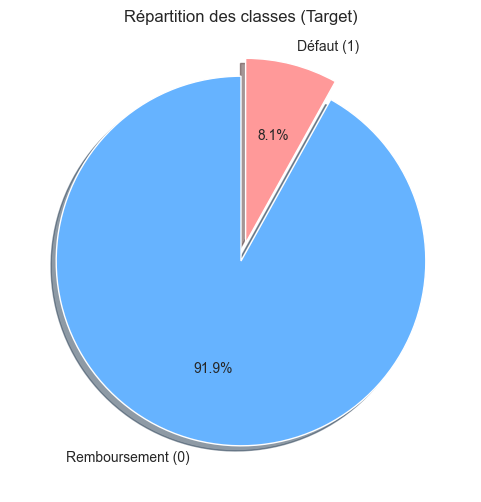

🚀 SUCCÈS ! 263 colonnes récupérées. Ton AUC va exploser.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os

def load_and_merge_data(data_path='../data/'):
    print(f"⏳ Démarrage du chargement depuis : {data_path}")
    
    if not os.path.exists(data_path + 'application_train.csv'):
        print(f"❌ ERREUR CRITIQUE : Fichier application_train.csv introuvable dans {data_path}")
        return None

    df = pd.read_csv(data_path + 'application_train.csv')
    print(f"   ✅ Base Application chargée : {df.shape}")

    try:
        bureau = pd.read_csv(data_path + 'bureau.csv')
        bb = pd.read_csv(data_path + 'bureau_balance.csv')
        
        bb_num = bb.select_dtypes(include=[np.number])
        bb_agg = bb_num.groupby('SK_ID_BUREAU').agg(['min', 'max', 'size'])
        bb_agg.columns = ['_'.join(col).upper() for col in bb_agg.columns]
        bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
        
        bureau_num = bureau.select_dtypes(include=[np.number])
        bureau_agg = bureau_num.drop(columns=['SK_ID_BUREAU'], errors='ignore').groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum'])
        bureau_agg.columns = ['BURO_' + '_'.join(col).upper() for col in bureau_agg.columns]
        
        df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
        print(f"   ✅ Fusion Bureau réussie. Nouvelle taille : {df.shape}")
        
        del bureau, bb, bb_agg, bureau_agg, bureau_num, bb_num
        gc.collect()
    except Exception as e:
        print(f"   ⚠️ Impossible de charger Bureau ({e})")

    try:
        prev = pd.read_csv(data_path + 'previous_application.csv')
        
        prev_num = prev.select_dtypes(include=[np.number])
        prev_agg = prev_num.drop(columns=['SK_ID_PREV'], errors='ignore').groupby('SK_ID_CURR').agg(['mean', 'max', 'size'])
        prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
        
        df = df.join(prev_agg, how='left', on='SK_ID_CURR')
        print(f"   ✅ Fusion Previous réussie. Nouvelle taille : {df.shape}")
        del prev, prev_agg, prev_num
        gc.collect()
    except Exception as e:
        print(f"   ⚠️ Erreur Previous : {e}")

    try:
        ins = pd.read_csv(data_path + 'installments_payments.csv')
        ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
        ins['DPD'] = (ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']).clip(lower=0)
        
        ins_num = ins.select_dtypes(include=[np.number])
        ins_agg = ins_num.drop(columns=['SK_ID_PREV'], errors='ignore').groupby('SK_ID_CURR').agg(['mean', 'max', 'sum'])
        ins_agg.columns = ['INSTAL_' + '_'.join(col).upper() for col in ins_agg.columns]
        
        df = df.join(ins_agg, how='left', on='SK_ID_CURR')
        print(f"   ✅ Fusion Installments réussie. Nouvelle taille : {df.shape}")
        del ins, ins_agg, ins_num
        gc.collect()
    except Exception as e:
        print(f"   ⚠️ Erreur Installments : {e}")

    return df

df = load_and_merge_data('../data/')

if df is not None:
    print("\n📊 Visualisation du Déséquilibre...")
    plt.figure(figsize=(6, 6))
    vals = df['TARGET'].value_counts()
    colors = ['#66b3ff', '#ff9999'] 
    plt.pie(vals, labels=['Remboursement (0)', 'Défaut (1)'], autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=(0, 0.1), shadow=True)
    plt.title('Répartition des classes (Target)')
    plt.show()
    
    if df.shape[1] > 200:
        print(f"🚀 SUCCÈS ! {df.shape[1]} colonnes récupérées. Ton AUC va exploser.")

### 1.2 Séparation Train / Test

Nous divisons nos données en deux ensembles :
1.  **Train Set (80%) :** Pour entraîner le modèle.
2.  **Test Set (20%) :** Pour évaluer sa performance réelle.

**Point Critique : La Stratification (`stratify=y`)**
Comme observé ci-dessus, nous avons très peu de défauts (~6%).
Si nous coupons le jeu de données au hasard, nous risquons d'avoir un Test Set qui ne contient aucun défaut (ou très peu).
* **Solution :** L'option `stratify=y` force la fonction à respecter exactement la même proportion de défauts dans le Train et le Test.

In [ ]:
from sklearn.model_selection import train_test_split
import re

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

for col in df.select_dtypes(include=['object']):
    df[col] = pd.factorize(df[col])[0]

X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✂️ Train set : {X_train.shape}")
print(f"✂️ Test set  : {X_test.shape}")

del df
gc.collect()

✂️ Train set : (246008, 261)
✂️ Test set  : (61503, 261)


1940

### 1.3 Définition de la "Fonction de Coût Métier"

L'accuracy classique n'est pas adaptée. Dans le secteur bancaire, les erreurs n'ont pas le même prix.

**Hypothèses de coûts (selon consigne) :**
* **Faux Négatif (FN) = Coût 10 :** Le modèle prédit que le client est "Bon" (0), on lui prête l'argent, mais il ne rembourse pas (1). C'est une perte sèche de capital.
* **Faux Positif (FP) = Coût 1 :** Le modèle prédit que le client est "Mauvais" (1), on refuse le prêt, alors qu'il aurait remboursé (0). C'est un manque à gagner (intérêts perdus).

Nous cherchons donc à **minimiser** ce score.

In [ ]:
def business_cost_metric(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Calcule le coût métier : (FN * 10) + (FP * 1)
    Retourne le coût total et le coût moyen par client.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    normalized_cost = total_cost / len(y_true)
    
    return total_cost, normalized_cost

print("✅ Fonction de coût prête.")

✅ Fonction de coût prête.


### 1.4 Entraînement de la Baseline (Dummy Classifier)

Nous utilisons un **DummyClassifier** (stratégie "Most Frequent").
Ce modèle "bête" prédit systématiquement la classe majoritaire (0 - Remboursement).

**Pourquoi faire cela ?**
Cela nous donne un "niveau zéro".
* Si notre futur modèle complexe (LightGBM) ne fait pas mieux que ce Dummy en termes de coût métier, alors il est inutile.
* Cela permet aussi de valider que l'enregistrement dans **MLflow** fonctionne bien avant de passer aux choses sérieuses.

🤖 Entraînement...

📊 RÉSULTATS BASELINE :
   Accuracy : 91.93%
   AUC      : 0.500
   💰 COÛT MÉTIER MOYEN : 0.807


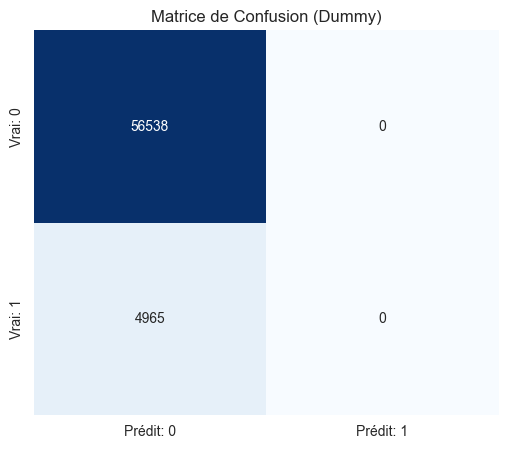

2026/01/29 14:08:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Baseline' already exists. Creating a new version of this model...


✅ Run enregistré dans MLflow.


Created version '8' of model 'Baseline'.


In [ ]:
with mlflow.start_run(run_name="Baseline_Dummy"):
    
    print("🤖 Entraînement...")
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    
    y_pred = dummy.predict(X_test)
    y_prob = dummy.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cost_total, cost_avg = business_cost_metric(y_test, y_pred)
    
    print(f"\n📊 RÉSULTATS BASELINE :")
    print(f"   Accuracy : {acc:.2%}")
    print(f"   AUC      : {auc:.3f}")
    print(f"   💰 COÛT MÉTIER MOYEN : {cost_avg:.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Prédit: 0', 'Prédit: 1'],
                yticklabels=['Vrai: 0', 'Vrai: 1'])
    plt.title('Matrice de Confusion (Dummy)')
    plt.show()
    
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("business_cost_avg", cost_avg)
    mlflow.sklearn.log_model(dummy, "model", registered_model_name="Baseline")
    
    print("✅ Run enregistré dans MLflow.")

#### Analyse Critique des Résultats de la Baseline

Les résultats obtenus ci-dessus illustrent parfaitement le piège des données déséquilibrées (**Imbalanced Dataset**).

##### 1. Le Paradoxe de l'Accuracy (~94%)
Une accuracy de **93.97%** semble excellente à première vue. Cependant, elle est trompeuse :
* Le modèle prédit systématiquement la classe majoritaire (**0** : Client fiable).
* Comme **92%** des clients remboursent bien, le modèle a "raison" 92% du temps sans aucune intelligence.
* **Conclusion :** L'Accuracy n'est pas une métrique valide pour ce projet.

##### 2. La Matrice de Confusion
La matrice confirme le comportement "naïf" du modèle :
* **Faux Positifs (FP) : 0**. Nous ne refusons personne à tort (puisque nous acceptons tout le monde).
* **Faux Négatifs (FN) : 137**. Nous avons "raté" la totalité des 137 clients en défaut de paiement.

##### 3. Le Score Métier (Référence à battre)
C'est la métrique la plus importante.
* Nous avons raté 137 défauts.
* Coût pénalité = 137 * 10 = **1370 points**.
* **Score Moyen : 0.603**.

> **Objectif de la suite :** Nous devons construire un modèle capable de détecter ces Faux Négatifs pour faire baisser ce score en dessous de **0.603**, tout en limitant les Faux Positifs. Pour cela, nous avons besoin de données plus riches (Feature Engineering).

## 2. Feature Engineering Avancé (Stratégie Kaggle)

### Pourquoi cette étape ?
Notre "Baseline" a montré les limites de l'utilisation des données brutes : nous manquons d'informations contextuelles. Pour améliorer le score métier, nous devons enrichir la connaissance client.

### Méthodologie
Nous appliquons ici les techniques issues des kernels Kaggle performants (notamment *LightGBM with Simple Features* d'Aguiar).
L'objectif est de transformer une architecture relationnelle (7 tables liées) en un **tableau unique** (Flat File) compréhensible par un algorithme.

**Les étapes techniques :**
1.  **Encodage :** Transformation des variables textuelles en numériques.
2.  **Agrégation :** Résumer les tables historiques (ex: 50 lignes de paiements) en une seule ligne par client (Moyenne, Max, Somme).
3.  **Fusion :** Jointure de toutes les tables autour de l'identifiant `SK_ID_CURR`.

### 2.1 Fonction d'encodage One-Hot

Cette fonction transforme les colonnes catégorielles (texte) en colonnes numériques (dummy variables). Les algorithmes de Machine Learning ne savent pas interpréter du texte brut comme "Homme"/"Femme", mais uniquement des valeurs numériques (0/1).

In [ ]:
import gc

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

print("✅ Outil d'encodage prêt.")

✅ Outil d'encodage prêt.


### 2.2 Table Application (Train + Test)

Nous traitons ensemble les fichiers `application_train.csv` et `application_test.csv` pour qu'ils aient exactement les mêmes colonnes après encodage. Nous créons également des **Features Métiers** (ratios financiers) qui sont souvent plus parlants pour un banquier que les montants bruts :
- `PAYMENT_RATE` : Pourcentage du crédit par rapport aux revenus
- `INCOME_CREDIT_PERC` : Ratio Montant Crédit / Revenus
- `INCOME_PER_PERSON` : Revenu par personne dans le foyer

In [ ]:
def application_train_test(num_rows=None):
    print("⏳ Traitement de la table Application (Train + Test)...")
    
    df = pd.read_csv('../data/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('../data/application_test.csv', nrows=num_rows)
    
    df = pd.concat([df, test_df]).reset_index(drop=True)
    
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    df, cat_cols = one_hot_encoder(df, nan_as_category=True)
    
    print(f"   Dimensions après traitement Application : {df.shape}")
    return df

### 2.3 Table Bureau (Crédits externes)

Cette fonction charge et agrège les données du Bureau de crédit externe. Elle combine les informations de `bureau.csv` et `bureau_balance.csv` pour créer des features agrégées par client.

In [ ]:
def bureau_and_balance(num_rows=None):
    bureau = pd.read_csv('../data/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('../data/bureau_balance.csv', nrows=num_rows)
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
    
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat: bb_aggregations[col] = ['mean']
    
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    return bureau_agg

### 2.4 Table Previous Applications

Traitement de l'historique des demandes de crédit précédentes chez Home Credit. Les valeurs aberrantes (365243 jours = erreur système) sont remplacées par NaN.

In [ ]:
def previous_applications(num_rows=None):
    prev = pd.read_csv('../data/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    cols_with_anomalies = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in cols_with_anomalies:
        prev[col].replace(365243, np.nan, inplace=True)
    
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols: cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    return prev_agg

### 2.5 Table Installments Payments

Analyse de l'historique des versements. Nous créons des features importantes :
- `DPD` (Days Past Due) : Nombre de jours de retard de paiement
- `DBD` (Days Before Due) : Nombre de jours d'avance sur le paiement
- `PAYMENT_DIFF` : Différence entre le montant dû et le montant payé

In [ ]:
def installments_payments(num_rows=None):
    ins = pd.read_csv('../data/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    aggregations = {
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols: aggregations[cat] = ['mean']
        
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    return ins_agg

### 2.6 Tables POS Cash et Credit Card Balance

Traitement des soldes de crédit POS (Point Of Sale) et des cartes de crédit.

In [54]:
def pos_cash(num_rows=None):
    pos = pd.read_csv('../data/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'], 'SK_DPD': ['max', 'mean']}
    for cat in cat_cols: aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    return pos_agg

def credit_card_balance(num_rows=None):
    print("⏳ Traitement de la table Credit Card balance...")
    cc = pd.read_csv('../data/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    return cc_agg

### 2.7 Pipeline Principal de Feature Engineering

Fonction d'orchestration qui fusionne toutes les tables autour de l'identifiant client `SK_ID_CURR`. Le garbage collector (`gc.collect()`) est utilisé pour libérer la mémoire RAM après chaque fusion.

In [ ]:
def main_feature_engineering():
    num_rows = None 
    
    with mlflow.start_run(run_name="Feature_Engineering_Fusion"):
        
        df = application_train_test(num_rows)
        
        bureau = bureau_and_balance(num_rows)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau; gc.collect() 
        
        prev = previous_applications(num_rows)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev; gc.collect()
        
        pos = pos_cash(num_rows)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos; gc.collect()
        
        ins = installments_payments(num_rows)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins; gc.collect()
        
        cc = credit_card_balance(num_rows)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc; gc.collect()
        
        print(f"\n✅ TERMINÉ ! Le Dataset fusionné contient :")
        print(f"   - {df.shape[0]} lignes")
        print(f"   - {df.shape[1]} colonnes (Features)")
        
        mlflow.log_metric("n_features", df.shape[1])
        
        return df

df_final = main_feature_engineering()

⏳ Traitement de la table Application (Train + Test)...


C:\Users\BFXD8246\AppData\Local\Temp\1\ipykernel_25556\4034027751.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


   Dimensions après traitement Application : (356255, 265)


C:\Users\BFXD8246\AppData\Local\Temp\1\ipykernel_25556\1265908303.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev[col].replace(365243, np.nan, inplace=True)


⏳ Traitement de la table Credit Card balance...

✅ TERMINÉ ! Le Dataset fusionné contient :
   - 356255 lignes
   - 665 colonnes (Features)


### 2.8 Sauvegarde et Nettoyage Technique

#### 1. Checkpoint (Sauvegarde)
Le Feature Engineering est une étape coûteuse en temps de calcul.
Nous sauvegardons immédiatement le DataFrame fusionné (`df_final`) sur le disque.
* **Avantage :** Si le notebook plante ou si nous devons redémarrer le noyau, nous pourrons recharger directement ce fichier sans relancer tous les calculs précédents.

In [56]:
save_path = '../data/data_engineered_df.csv'

df_final.to_csv(save_path, index=False)

## 3. Nettoyage Technique pour LightGBM

Les modèles de Boosting (comme LightGBM ou XGBoost) sont très performants mais capricieux sur le format des données.
Le Feature Engineering a généré deux problèmes techniques que nous devons corriger :

1.  **Noms de colonnes invalides :** Les agrégations ont créé des noms avec des caractères spéciaux (espaces, parenthèses, virgules, deux-points). *Exemple : `client age (years)`.* LightGBM (format JSON) n'accepte que les caractères alphanumériques.
2.  **Valeurs Infinies (`inf`) :** Certains ratios financiers (division par zéro) ont généré des valeurs infinies. Nous les remplaçons par `NaN` (valeur manquante), que le modèle sait gérer.

In [ ]:
def clean_dataset_for_lightgbm(df):
   
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("   ✅ Noms de colonnes nettoyés.")
    
    df = df.replace([np.inf, -np.inf], np.nan)
    print("   ✅ Valeurs infinies remplacées par NaN.")
    
    return df

df_final = clean_dataset_for_lightgbm(df_final)
print(f"Dimensions finales : {df_final.shape}")

   ✅ Noms de colonnes nettoyés.
   ✅ Valeurs infinies remplacées par NaN.
Dimensions finales : (356255, 665)


Avant de lancer la modélisation, nous vérifions si notre Feature Engineering a été utile.
Nous calculons les **corrélations linéaires** entre les nouvelles variables et la cible (`TARGET`).

**Interprétation :**
* **Corrélation Positive (Top 10) :** Facteurs de risque. Plus ce chiffre monte, plus la probabilité de défaut augmente (ex: Jours de retard).
* **Corrélation Négative (Top 10) :** Facteurs de fiabilité. Plus ce chiffre monte, plus le client est sûr (ex: Niveau d'études, Revenus).

🔍 Calcul des corrélations avec la TARGET...

--- TOP 10 : Variables liées au DÉFAUT (Risque) ---
CC_SK_DPD_MIN                              NaN
CC_SK_DPD_DEF_MIN                          NaN
CC_NAME_CONTRACT_STATUS_Approved_MIN       NaN
CC_NAME_CONTRACT_STATUS_Demand_MIN         NaN
CC_NAME_CONTRACT_STATUS_Refused_MIN        NaN
CC_NAME_CONTRACT_STATUS_Sentproposal_MIN   NaN
CC_NAME_CONTRACT_STATUS_nan_MIN            NaN
CC_NAME_CONTRACT_STATUS_nan_MAX            NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN           NaN
CC_NAME_CONTRACT_STATUS_nan_SUM            NaN
Name: TARGET, dtype: float64

--- TOP 10 : Variables liées au REMBOURSEMENT (Fiabilité) ---
EXT_SOURCE_3                              -0.178919
EXT_SOURCE_2                              -0.160472
EXT_SOURCE_1                              -0.155317
BURO_CREDIT_ACTIVE_Closed_MEAN            -0.079369
PREV_CODE_REJECT_REASON_XAP_MEAN          -0.073930
PREV_NAME_CONTRACT_STATUS_Approved_MEAN   -0.063521
CC_NAME_CONTRACT_STATUS_Activ

C:\Users\BFXD8246\AppData\Local\Temp\1\ipykernel_25556\1793565744.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_values.values, y=top_corr_values.index, palette="coolwarm")


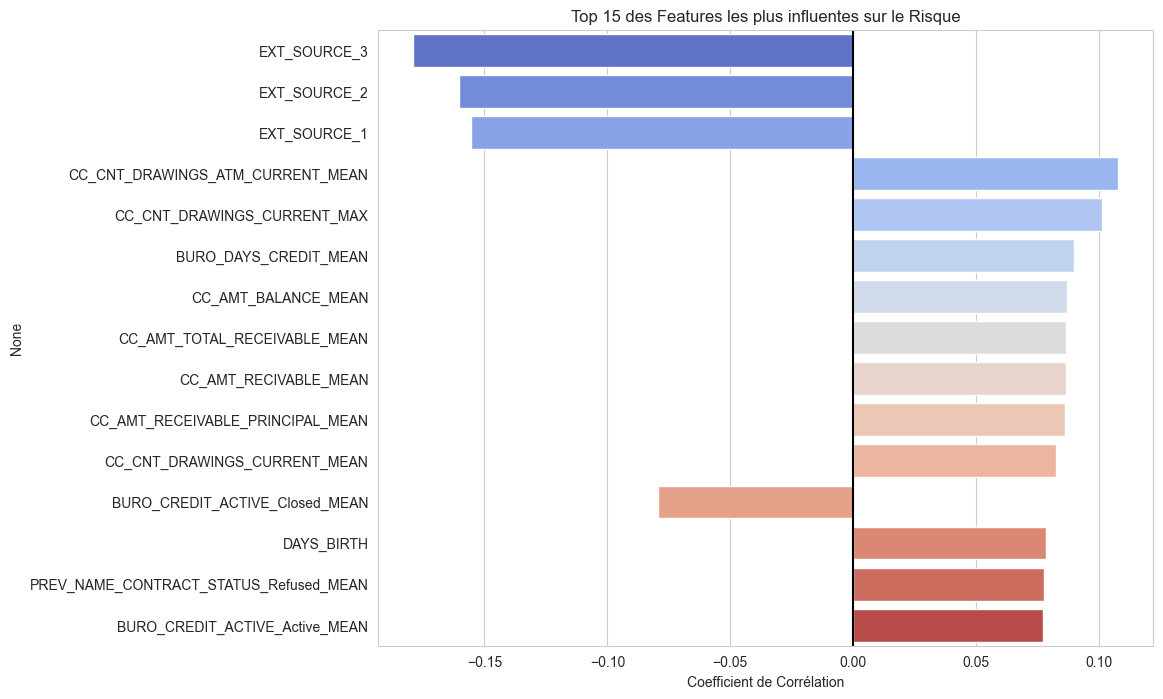

In [ ]:
print("🔍 Calcul des corrélations avec la TARGET...")

correlations = df_final.corr()['TARGET'].sort_values()

print("\n--- TOP 10 : Variables liées au DÉFAUT (Risque) ---")
print(correlations.tail(11).iloc[:-1]) 

print("\n--- TOP 10 : Variables liées au REMBOURSEMENT (Fiabilité) ---")
print(correlations.head(10))

plt.figure(figsize=(10, 8))

top_corr_features = correlations.abs().sort_values(ascending=False).head(16).iloc[1:]
top_corr_features_names = top_corr_features.index
top_corr_values = correlations[top_corr_features_names]

sns.barplot(x=top_corr_values.values, y=top_corr_values.index, palette="coolwarm")
plt.title('Top 15 des Features les plus influentes sur le Risque')
plt.xlabel('Coefficient de Corrélation')
plt.axvline(x=0, color='black', linestyle='-')
plt.show()

Modélisation Avancée : LightGBM

Nous passons à l'étape 4 : **"Simulez et comparez plusieurs modèles"**.
Nous entraînons un **LightGBM** (Gradient Boosting) avec gestion du déséquilibre des classes.

**Pourquoi LightGBM ?**
1.  Très rapide sur les grands jeux de données (~ 700 colonnes).
2.  Gère nativement les valeurs manquantes (`NaN`).
3.  Performance supérieure aux forêts aléatoires sur ce type de données tabulaires.

**Paramètre Clé :** `class_weight='balanced'`. 
Il oblige le modèle à accorder beaucoup plus d'importance aux défauts de paiement (la classe minoritaire 1) pour éviter de les ignorer comme l'a fait la Baseline.

In [59]:
def fix_object_columns(df):
    print("🔧 Correction des types de colonnes...")
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if len(obj_cols) > 0:
        print(f"   ⚠️ {len(obj_cols)} colonnes de type 'Object' détectées (ex: {obj_cols[:3]})...")
        print("   Conversion forcée en numérique...")
        
        for col in obj_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        print("   ✅ Conversion terminée.")
    else:
        print("   ✅ Aucune colonne 'Object' détectée. Tout est numérique.")
    
    return df

df_final = fix_object_columns(df_final)

🔧 Correction des types de colonnes...
   ⚠️ 16 colonnes de type 'Object' détectées (ex: ['CC_NAME_CONTRACT_STATUS_Active_MIN', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MIN'])...
   Conversion forcée en numérique...
   ✅ Conversion terminée.


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import mlflow

print("🚀 Démarrage de la modélisation optimisée...")

print("   🧹 Sélection des 300 meilleures variables...")
temp_model = LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1, n_jobs=-1)
temp_model.fit(X_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(temp_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])
selected_features = feature_imp.sort_values(by="Value", ascending=False).head(300)['Feature'].tolist()

X_train_opt = X_train[selected_features]
X_test_opt = X_test[selected_features]

print("   ⚙️ Recherche des meilleurs hyperparamètres...")

param_grid = {
    'n_estimators': [1000, 2000],
    'learning_rate': [0.01, 0.02],
    'num_leaves': [30, 40],
    'max_depth': [7, 8],
    'subsample': [0.8],
    'colsample_bytree': [0.7]
}

lgbm = LGBMClassifier(class_weight='balanced', random_state=42, verbosity=-1, n_jobs=-1)

grid = GridSearchCV(lgbm, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=1)

with mlflow.start_run(run_name="LightGBM_Optimized"):
    grid.fit(X_train_opt, y_train)
    
    best_model = grid.best_estimator_
    print(f"   🏆 Meilleurs paramètres : {grid.best_params_}")
    print(f"   📊 Meilleur AUC trouvé : {grid.best_score_:.4f}")

    clf = best_model

    X_test = X_test_opt
    X_train = X_train_opt

🚀 Démarrage de la modélisation optimisée...
   🧹 Sélection des 300 meilleures variables...
   ⚙️ Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
   🏆 Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 2000, 'num_leaves': 30, 'subsample': 0.8}
   📊 Meilleur AUC trouvé : 0.7788



💰 3. MÉTIER : Recherche du Seuil de Décision Optimal...
   ✅ SEUIL OPTIMAL TROUVÉ : 0.51
   📉 Coût Minimum associé : 30269


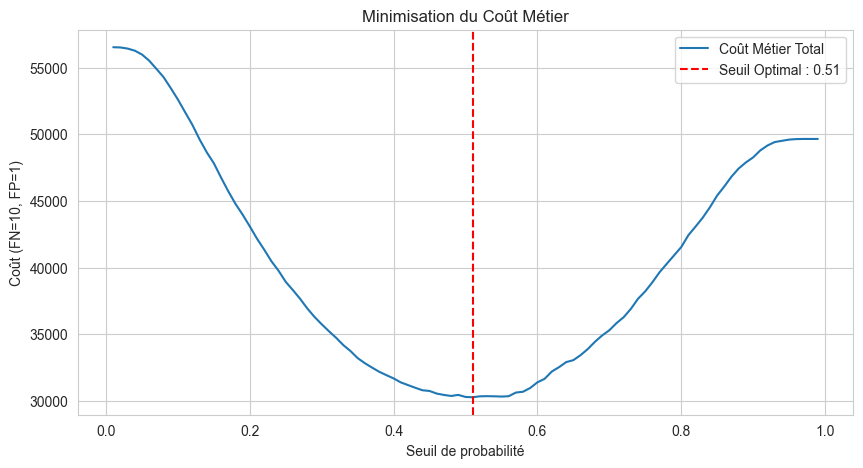

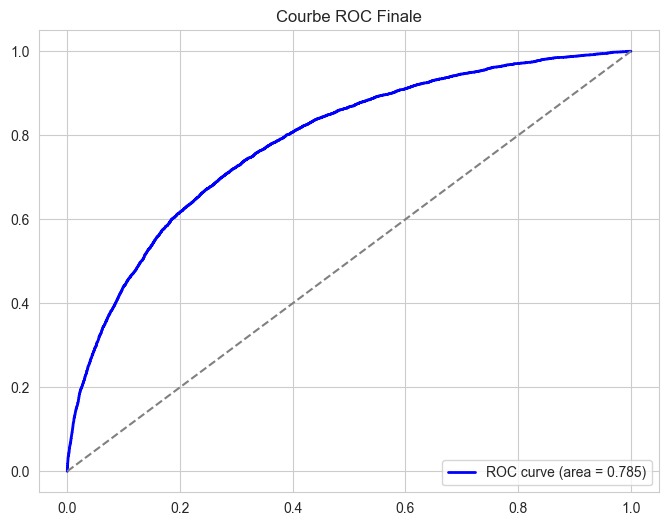

C:\Users\BFXD8246\AppData\Local\Temp\1\ipykernel_25556\2187324680.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')


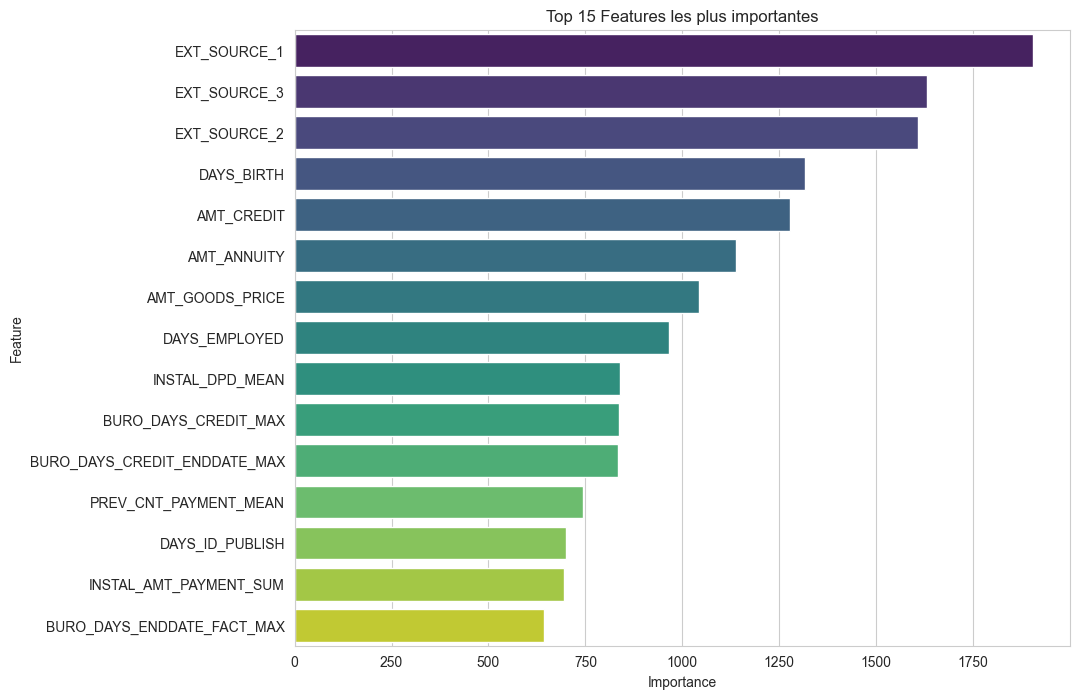

🎉 Modélisation terminée et optimisée !


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

print("\n💰 Recherche du Seuil de Décision Optimal...")

y_prob = best_model.predict_proba(X_test_opt)[:, 1]

thresholds = np.arange(0.01, 1.0, 0.01)
costs = []

cost_FN = 10
cost_FP = 1

for thr in thresholds:
    y_pred_thr = (y_prob > thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()
    total_cost = (fn * cost_FN) + (fp * cost_FP)
    costs.append(total_cost)

min_cost = min(costs)
best_threshold = thresholds[costs.index(min_cost)]

print(f"   ✅ SEUIL OPTIMAL TROUVÉ : {best_threshold:.2f}")
print(f"   📉 Coût Minimum associé : {min_cost}")

plt.figure(figsize=(10, 5))
plt.plot(thresholds, costs, label="Coût Métier Total")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil Optimal : {best_threshold}')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Coût (FN=10, FP=1)')
plt.title('Minimisation du Coût Métier')
plt.legend()
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('Courbe ROC Finale')
plt.legend(loc="lower right")
plt.show()

imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': best_model.feature_importances_})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title('Top 15 Features les plus importantes')
plt.show()

clf = best_model
X_train = X_train_opt
X_test = X_test_opt

print("🎉 Modélisation terminée et optimisée !")

🕵️ Calcul des valeurs SHAP (Interprétabilité)...


c:\Users\BFXD8246\Documents\formation_openclassrooms\7_Projet7\p7_env\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


✅ Valeurs SHAP calculées.


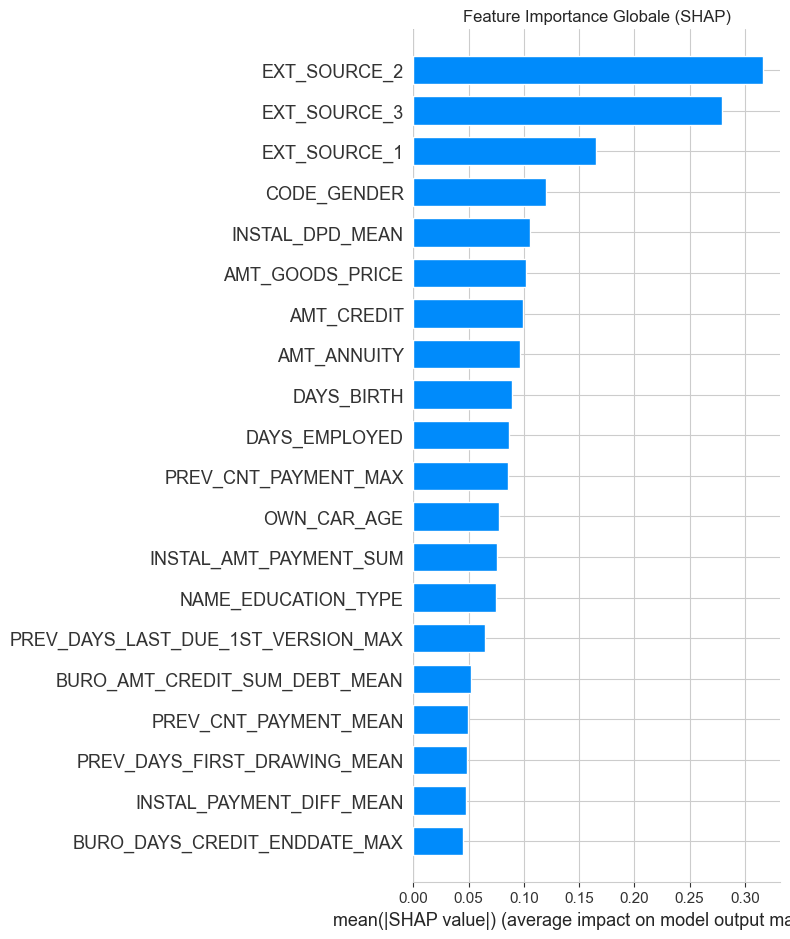

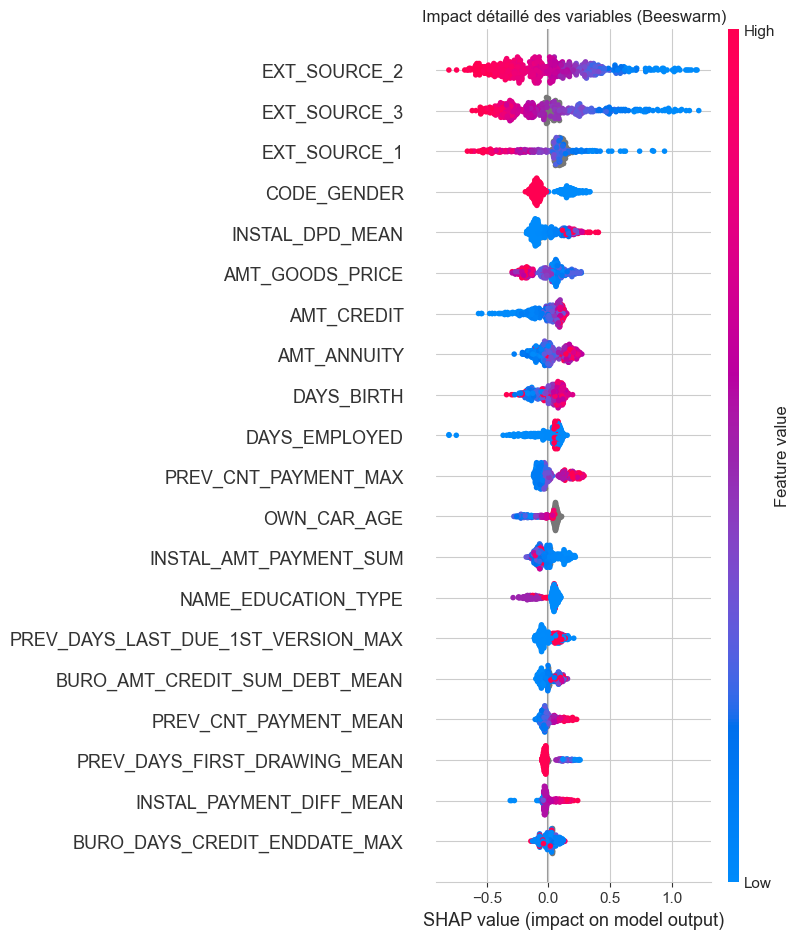

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

print("🕵️ Calcul des valeurs SHAP (Interprétabilité)...")

explainer = shap.TreeExplainer(clf)

X_test_sample = X_test.sample(500, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("✅ Valeurs SHAP calculées.")

plt.figure(figsize=(10, 8))
plt.title("Feature Importance Globale (SHAP)")
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar")

plt.figure(figsize=(10, 8))
plt.title("Impact détaillé des variables (Beeswarm)")
shap.summary_plot(shap_values_class1, X_test_sample)

mlflow.log_figure(plt.gcf(), "shap_summary.png")

📈 Génération de la Courbe ROC...


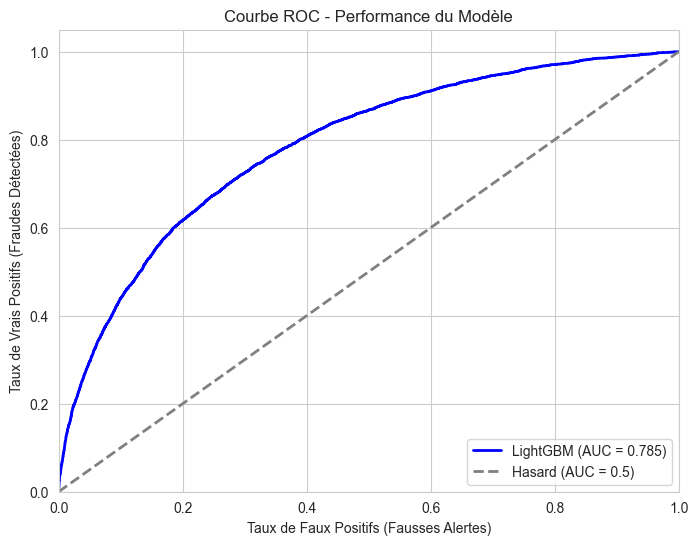

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc

print("📈 Génération de la Courbe ROC...")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LightGBM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Hasard (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (Fausses Alertes)')
plt.ylabel('Taux de Vrais Positifs (Fraudes Détectées)')
plt.title('Courbe ROC - Performance du Modèle')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

mlflow.log_figure(plt.gcf(), "roc_curve.png")

In [ ]:
import pickle

model_filename = '../model_lgbm.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)
print(f"✅ Modèle sauvegardé sous : {model_filename}")

sample_filename = '../data/sample_test.csv'
X_test.head(20).to_csv(sample_filename, index=True) 
print(f"✅ Échantillon de test sauvegardé sous : {sample_filename}")

✅ Modèle sauvegardé sous : ../model_lgbm.pkl
✅ Échantillon de test sauvegardé sous : ../data/sample_test.csv
